## **2. Nodes' Contribution (Q2)**

*In any network, certain nodes (airports, in this case) play a critical role in maintaining connectivity and flow. Centrality measures are used to identify these nodes.*

**Your Task:**
Implement a function analyze_centrality(flight_network, airport) that computes the following centrality measures for a given airport:

- Betweenness centrality: Measures how often a node appears on the shortest paths between other nodes.
- Closeness centrality: Measures how easily a node can access all other nodes in the network.
- Degree centrality: Simply counts the number of direct connections to the node.
- PageRank: Computes the "importance" of a node based on incoming connections and their weights.

Write a function compare_centralities(flight_network) to:

- Compute and compare centrality values for all nodes in the graph.
- Plot centrality distributions (histograms for each centrality measure).
- Return the top 5 airports for each centrality measure.
- Ask LLM (eg. ChatGPT) to suggest alternative centrality measures that might be relevant to this task. How can you check that the results given by the LLM are trustable?

Implement one of these measures suggested by the LLM, compare its results to the centralities you've already computed, and analyze whether it adds any new insights.

In [ ]:
import zipfile
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords

from collections import defaultdict

import random

from tqdm import tqdm

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score


import time

In [4]:
!pip install kaggle

!kaggle datasets download flashgordon/usa-airport-dataset

  Preparing metadata (setup.py) ... done
  Using cached bleach-6.2.0-py3-none-any.whl.metadata (30 kB)
Using cached bleach-6.2.0-py3-none-any.whl (163 kB)
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=fe0ae52b2f2e141ab3e349e43df0298c05b194d1a5d0797002361c99ee3dc19f
  Stored in directory: /Users/roberto/Library/Caches/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
Dataset URL: https://www.kaggle.com/datasets/flashgordon/usa-airport-dataset
License(s): CC0-1.0
100%|██████████████████████████████████████| 40.8M/40.8M [00:01<00:00, 38.8MB/s]
100%|██████████████████████████████████████| 40.8M/40.8M [00:01<00:00, 24.6MB/s]


In [8]:
# Unzip the file we downloaded from kaggle
zip_file_path = 'usa-airport-dataset.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('.')  # Extract files to the current working directory

In [9]:
# Save CSV files in pandas df
airport2 = pd.read_csv('Airports2.csv')

### EDA
##### *just to take a view of the dataset structure*

In [10]:
airport2.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


In [17]:
airport2.shape

(3606803, 15)

In [15]:
(airport2.info)

<bound method DataFrame.info of         Origin_airport Destination_airport         Origin_city  \
0                  MHK                 AMW       Manhattan, KS   
1                  EUG                 RDM          Eugene, OR   
2                  EUG                 RDM          Eugene, OR   
3                  EUG                 RDM          Eugene, OR   
4                  MFR                 RDM         Medford, OR   
...                ...                 ...                 ...   
3606798            STL                 TBN       St. Louis, MO   
3606799            STL                 TBN       St. Louis, MO   
3606800            STL                 TBN       St. Louis, MO   
3606801            CGI                 TBN  Cape Girardeau, MO   
3606802            FWA                 OH1      Fort Wayne, IN   

                   Destination_city  Passengers  Seats  Flights  Distance  \
0                          Ames, IA          21     30        1       254   
1                    

In [18]:
airport2.describe()

,Passengers,Seats,Flights,Distance,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
count,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.599849e+06,3.599849e+06,3.599996e+06,3.599996e+06
mean,2.688910e+03,4.048297e+03,3.722890e+01,6.973190e+02,5.871502e+06,5.897982e+06,3.775029e+01,-9.186178e+01,3.774091e+01,-9.183433e+01
std,4.347617e+03,6.200871e+03,4.961970e+01,6.044165e+02,7.858062e+06,7.906127e+06,5.765453e+00,1.653773e+01,5.736556e+00,1.647228e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300500e+04,1.288700e+04,1.972140e+01,-1.579220e+02,1.972140e+01,-1.579220e+02
25%,1.090000e+02,1.560000e+02,2.000000e+00,2.730000e+02,1.030597e+06,1.025470e+06,3.363670e+01,-9.703800e+01,3.363670e+01,-9.703800e+01
50%,1.118000e+03,1.998000e+03,2.500000e+01,5.190000e+02,2.400193e+06,2.400193e+06,3.885210e+01,-8.775240e+01,3.885210e+01,-8.775240e+01
75%,3.503000e+03,5.370000e+03,5.500000e+01,9.270000e+02,8.613622e+06,8.635706e+06,4.173260e+01,-8.029060e+01,4.173260e+01,-8.029060e+01
max,8.959700e+04,1.470620e+05,1.128000e+03,5.095000e+03,3.813959e+07,3.813959e+07,6.483750e+01,-6.882810e+01,6.483750e+01,-6.882810e+01


In [20]:
airport2.columns.tolist()

['Origin_airport',
 'Destination_airport',
 'Origin_city',
 'Destination_city',
 'Passengers',
 'Seats',
 'Flights',
 'Distance',
 'Fly_date',
 'Origin_population',
 'Destination_population',
 'Org_airport_lat',
 'Org_airport_long',
 'Dest_airport_lat',
 'Dest_airport_long']

In [21]:
airport2.isnull().sum()

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
dtype: int64

In [22]:
airport2.nunique()

Origin_airport              683
Destination_airport         708
Origin_city                 535
Destination_city            548
Passengers                37484
Seats                     41098
Flights                     920
Distance                   2776
Fly_date                    240
Origin_population          6679
Destination_population     6696
Org_airport_lat             477
Org_airport_long            477
Dest_airport_lat            484
Dest_airport_long           484
dtype: int64

In [23]:
import seaborn as sns

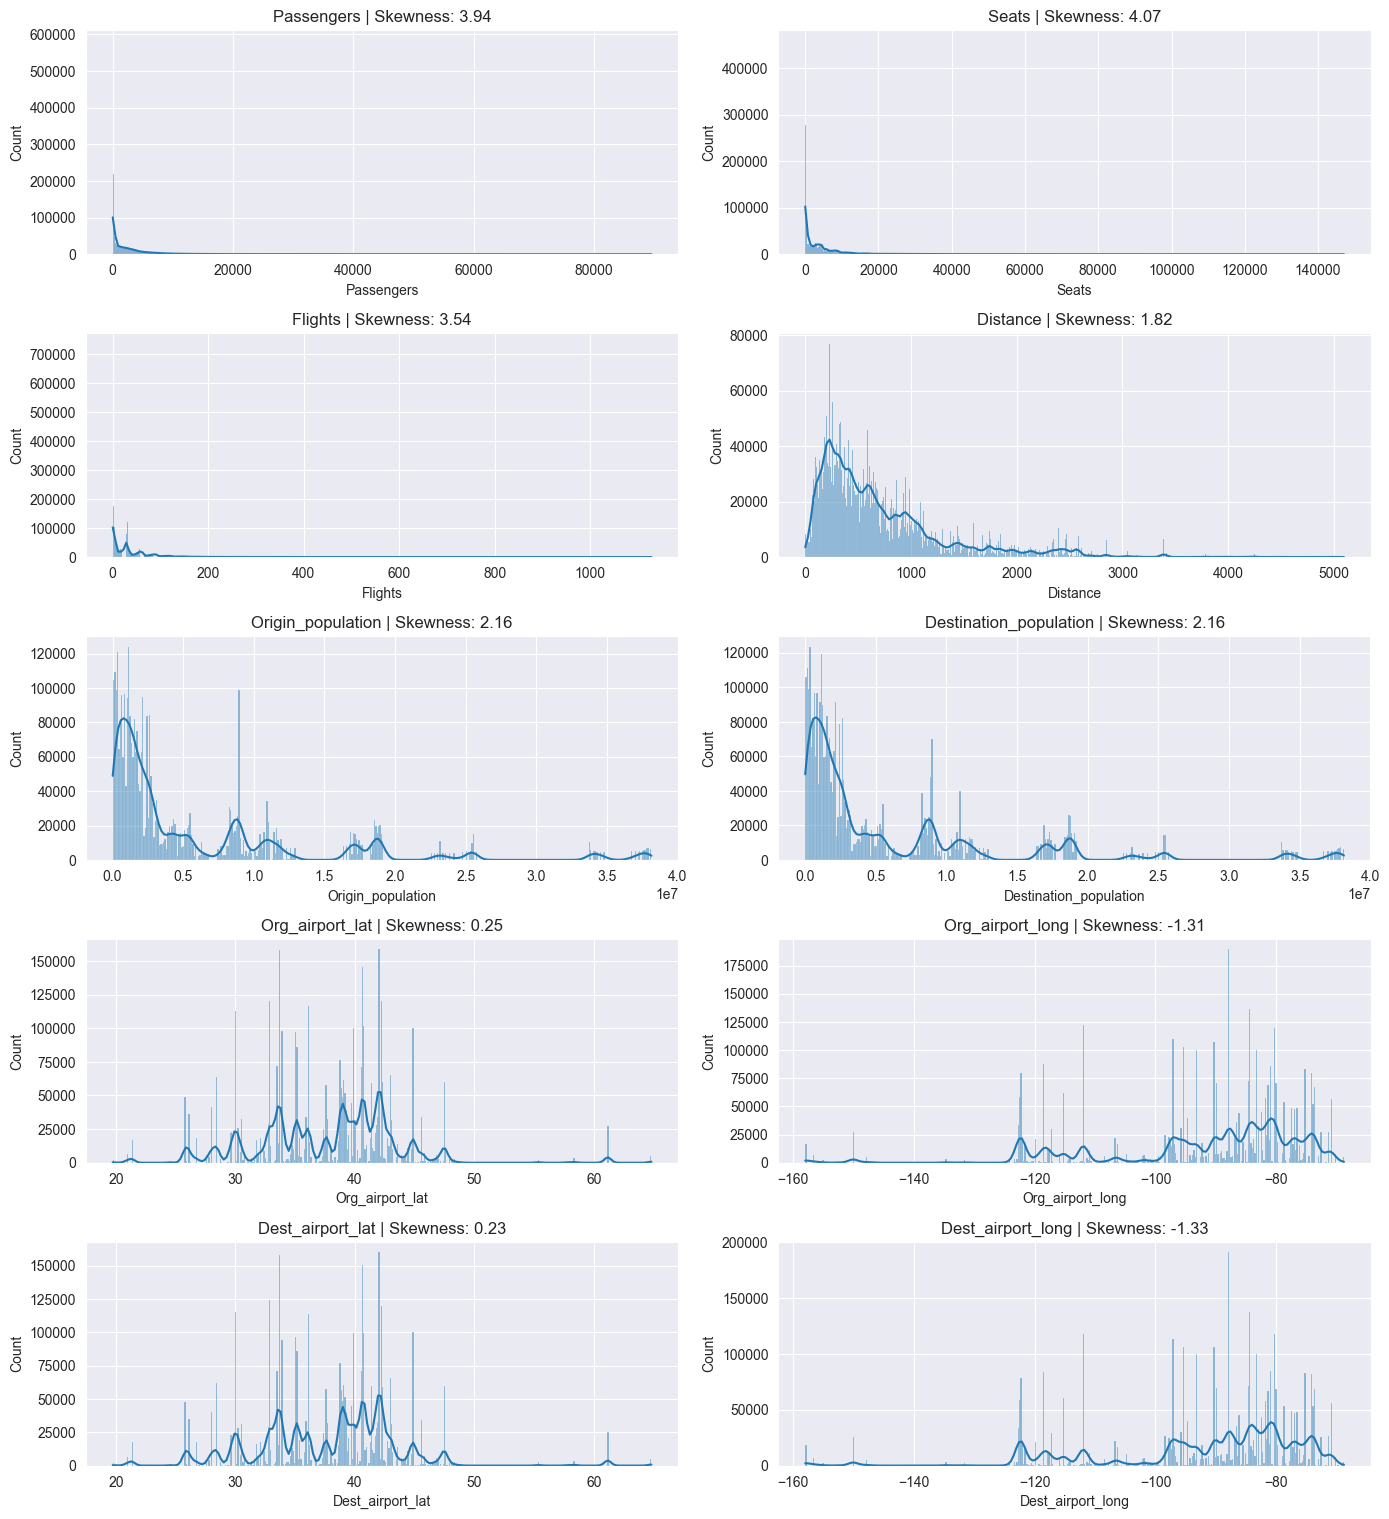

In [25]:
# Set Seaborn style
sns.set_style("darkgrid")

# Identify numerical columns
numerical_columns = airport2.select_dtypes(include=["int64", "float64"]).columns

# Plot distribution of each numerical feature
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(airport2[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(airport2[feature].skew(), 2)}")

# Adjust layout and show plots
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

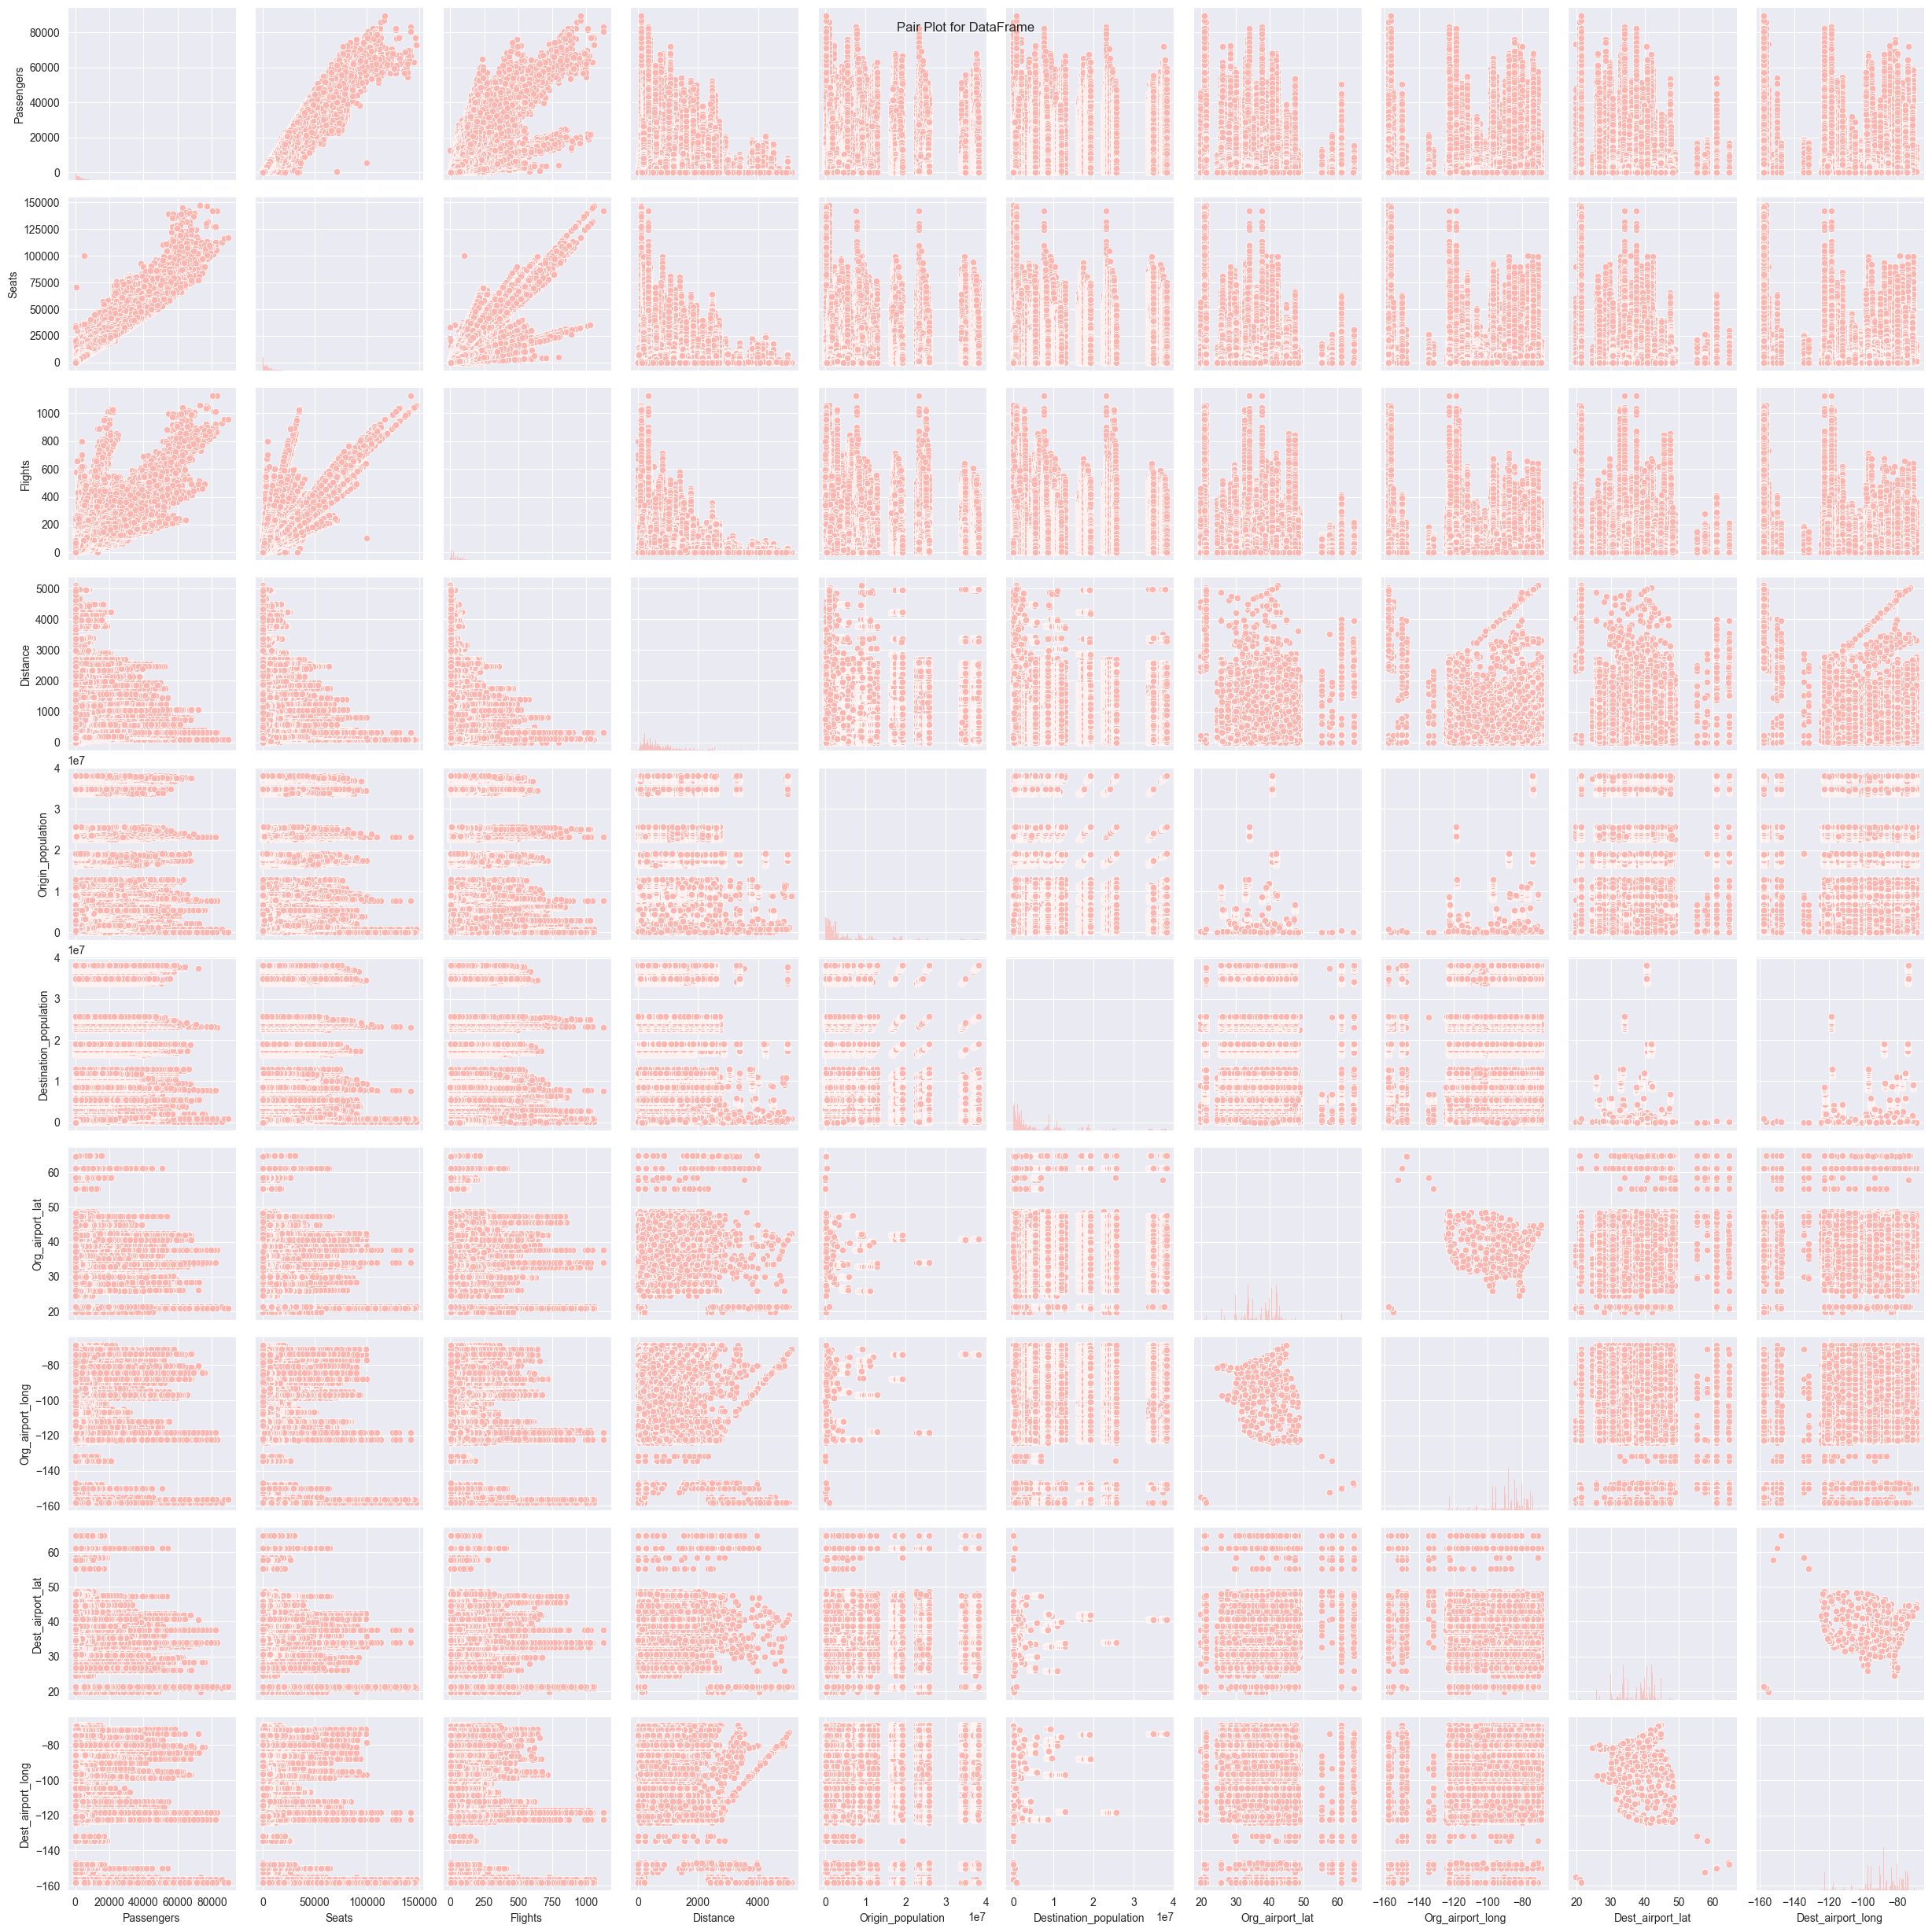

In [28]:
# Set the color palette
sns.set_palette("Pastel1")

# Assuming 'df' is your DataFrame
plt.figure(figsize=(10, 6))

# Using Seaborn to create a pair plot with the specified color palette
sns.pairplot(airport2)

plt.suptitle('Pair Plot for DataFrame')
plt.show()

# Explanation of Centrality Measures Mathematically

This document explains the **mathematics** behind the centrality measures you are implementing for your flight network. The centrality measures discussed here are:

1. **Betweenness Centrality**
2. **Closeness Centrality**
3. **Degree Centrality**

---

## **1. Betweenness Centrality**

### **Definition**
Betweenness centrality measures how often a node lies on the shortest paths between other nodes in a graph. It quantifies the importance of a node in controlling communication or flow within a network.

### **Mathematical Formula**
For a node $v$, betweenness centrality is:
$$
C_B(v) = \sum_{s \neq v \neq t} \frac{\sigma_{s,t}(v)}{\sigma_{s,t}}
$$
Where:
- $\sigma_{s,t} $: Total number of shortest paths from node $ s $to $ t $.
- $\sigma_{s,t}(v) $: Number of those paths that pass through $v $.

### **Steps to Compute Betweenness Centrality**
1. For each pair of nodes $s $ and $ t$in the graph:
   - Compute all shortest paths between $ s $ and $t $.
   - Count how many of these paths pass through the node $v$.
2. Sum the fraction of paths that pass through $v$ for all $s$ and $t$, where $s$ $\neq v \neq t$.

---

## **2. Closeness Centrality**

### **Definition**
Closeness centrality measures how "close" a node is to all other nodes in the network. It is the reciprocal of the average shortest path distance from the node to all other nodes.

### **Mathematical Formula**
For a node $ v $, closeness centrality is:
$$
C_C(v) = \frac{1}{\sum_{u \in V} d(v, u)}
$$
Where:
- $ d(v, u) $: Shortest distance from node $v$ to node $u$.
- $V$: Set of all nodes in the graph.

### **Steps to Compute Closeness Centrality**
1. Compute the shortest path from $v$ to every other node $u$ in the graph.
2. Sum up all these shortest path distances: $ \text{Total Distance} = \sum_{u} d(v, u)$.
3. Take the reciprocal of the total distance to get closeness centrality.

---

## **3. Degree Centrality**

### **Definition**
Degree centrality is the simplest centrality measure. It counts the number of direct connections (edges) a node has in the graph.

### **Mathematical Formula**
For a node $v$, degree centrality is:
$$
C_D(v) = \text{degree}(v)
$$
Where:
- $\text{degree}(v) $: Number of edges connected to node $v$.

### **Steps to Compute Degree Centrality**
1. Count all the direct neighbors (connections) of node $v$.
2. If the graph is **directed**, you can compute:
   - **In-degree**: Number of edges coming into $v$.
   - **Out-degree**: Number of edges going out of $v$.

---

## **Comparing Centrality Measures**

To compare the centrality measures (e.g., closeness, betweenness, and degree), you can:
1. Normalize the centrality values so that they are comparable across nodes.
2. Use scatter plots or rankings to analyze how each airport (node) ranks differently based on the chosen measure.
3. Analyze the network's structural role for each node based on its centrality score.

---

## **General Notes**

- **Graph Representation:** Ensure your graph is correctly represented with nodes as airports and edges as direct flights.
- **Shortest Paths:** Use algorithms like Dijkstra’s or Floyd-Warshall to compute shortest paths efficiently.
- **Directed vs. Undirected:** Take into account whether your network is directed (flights have direction) or undirected.

By understanding these mathematical concepts, you can confidently implement and interpret centrality measures in your network analysis.

# Centrality Measures in Networks: A Comprehensive Guide

This document provides a detailed explanation of how to calculate four major centrality measures for a network, focusing on their mathematical definitions, implementation logic, and coding steps. These measures are:
1. **Betweenness Centrality**
2. **Closeness Centrality**
3. **Degree Centrality**
4. **PageRank**

---

## **1. Betweenness Centrality**

### **Definition**
Betweenness centrality quantifies the number of times a node lies on the shortest paths between pairs of other nodes in a graph. It measures the importance of a node in controlling information flow.

$$
C_B(v) = \sum_{s \neq v \neq t} \frac{\sigma_{s,t}(v)}{\sigma_{s,t}}
$$

Where:
- $ \sigma_{s,t} $: Total number of shortest paths from node $ s $ to node $ t $.
- $ \sigma_{s,t}(v) $: Number of shortest paths from $s$ to $t$ that pass through $ v $.

### **Steps to Calculate**
1. Compute all shortest paths for every pair of nodes $ (s, t)$.
2. Count the paths that pass through the target node $v$.
3. For each pair $(s, t) $, calculate the fraction $ \frac{\sigma_{s,t}(v)}{\sigma_{s,t}} $.
4. Sum these fractions for all $s, t$ pairs.

### **Implementation Logic**
- Use **Breadth-First Search (BFS)** for unweighted graphs or **Dijkstra’s Algorithm** for weighted graphs to calculate shortest paths.
- Track how many paths pass through the target node.

---


In [ ]:
def compute_betweenness_centrality(graph, airport):
    nodes = list(graph.keys())
    betweenness = 0

    for source in nodes:
        for target in nodes:
            if source == target or source == airport or target == airport:
                continue
            # Compute all shortest paths from source to target
            paths = find_all_shortest_paths(graph, source, target)
            total_paths = len(paths)
            passing_paths = sum(1 for path in paths if airport in path)
            betweenness += passing_paths / total_paths

    return betweenness

def find_all_shortest_paths(graph, source, target):
    # Perform BFS to find all shortest paths
    queue = [[source]]
    shortest_paths = []
    visited = set()

    while queue:
        path = queue.pop(0)
        node = path[-1]

        if node in visited:
            continue
        visited.add(node)

        for neighbor in graph[node]:
            new_path = list(path)
            new_path.append(neighbor)

            if neighbor == target:
                shortest_paths.append(new_path)
            else:
                queue.append(new_path)

    return shortest_paths

## **2. Closeness Centrality**

### **Definition**
Closeness centrality measures how close a node is to all other nodes in the network. It is calculated as the reciprocal of the sum of the shortest path distances from a node to all other nodes.

$$
C_C(v) = \frac{1}{\sum_{u \in V} d(v, u)}
$$

Where:
- $ d(v, u)$: Shortest path distance from node $ v$ to node $u$.
- $ V $: Set of all nodes in the graph.

### **Steps to Calculate**
1. Compute the shortest path distances $d(v, u)$ from the target node $ v $ to all other nodes $ u$.
2. Sum these distances.
3. Take the reciprocal of the total distance.

### **Implementation Logic**
- Perform a BFS or Dijkstra’s algorithm starting from the target node $v$ to calculate all shortest path distances.
- Ensure the result accounts for disconnected nodes (i.e., distances that remain infinite).

---

In [ ]:
def compute_closeness_centrality(graph, airport):
    distances = bfs_shortest_distances(graph, airport)
    total_distance = sum(distances.values())
    if total_distance > 0:
        return 1 / total_distance
    else:
        return 0

def bfs_shortest_distances(graph, start):
    # BFS to compute shortest distances
    distances = {node: float('inf') for node in graph.keys()}
    distances[start] = 0
    queue = [start]

    while queue:
        current = queue.pop(0)

        for neighbor in graph[current]:
            if distances[neighbor] == float('inf'):  # Not visited
                distances[neighbor] = distances[current] + 1
                queue.append(neighbor)

    return distances

## **3. Degree Centrality**

### **Definition**
Degree centrality is the simplest measure and counts the number of direct connections a node has.

$$
C_D(v) = \text{degree}(v)
$$

Where:
- $ \text{degree}(v) $: Number of edges directly connected to the node $v$.

### **Steps to Calculate**
1. Count the number of neighbors of the target node $v$.
2. For directed graphs:
   - Compute **in-degree**: Number of incoming edges.
   - Compute **out-degree**: Number of outgoing edges.

### **Implementation Logic**
- Traverse the graph to count the neighbors of the node.
- For weighted graphs, optionally sum the edge weights.

---

In [ ]:
def compute_degree_centrality(graph, airport):
    return len(graph[airport])

## **4. PageRank**

### **Definition**
PageRank is an iterative algorithm that calculates the importance of a node based on its incoming connections. The rank of a node depends on the rank of its neighbors, with a damping factor to ensure convergence.

$$
PR(v) = \frac{1 - \alpha}{N} + \alpha \sum_{u \in \text{In}(v)} \frac{PR(u)}{\text{OutDegree}(u)}
$$

Where:
- $ \alpha $: Damping factor, typically set to 0.85.
- $ N $: Total number of nodes.
- $ \text{In}(v) $: Set of nodes linking to $ v $.
- $ \text{OutDegree}(u) $: Number of outgoing edges from node $u $.

### **Steps to Calculate**
1. Initialize all nodes with an equal rank $ \frac{1}{N} $.
2. Iteratively update ranks based on the ranks of incoming neighbors.
3. Stop when the change in ranks is below a tolerance threshold.

### **Implementation Logic**
- Normalize ranks at each step to ensure they sum to 1.
- Use a convergence threshold (e.g., $ 10^{-6} $) to terminate the iteration.


In [ ]:
def compute_pagerank(graph, airport, alpha=0.85, max_iter=100, tol=1e-6):
    nodes = list(graph.keys())
    N = len(nodes)
    pagerank = {node: 1 / N for node in nodes}
    new_pagerank = pagerank.copy()

    for _ in range(max_iter):
        for node in nodes:
            new_pagerank[node] = (1 - alpha) / N
            for neighbor in graph:
                if node in graph[neighbor]:
                    new_pagerank[node] += alpha * (pagerank[neighbor] / len(graph[neighbor]))

        # Check for convergence
        if max(abs(new_pagerank[node] - pagerank[node]) for node in nodes) < tol:
            break
        pagerank = new_pagerank.copy()

    return pagerank.get(airport, 0)

##### **References**
1.	Wikipedia: Centrality : <https://en.wikipedia.org/wiki/Centrality>

2.	GeeksforGeeks: Graph Algorithms : <https://www.geeksforgeeks.org/graph-data-structure-and-algorithms/>

3.	PageRank Algorithm Explained : <https://en.wikipedia.org/wiki/PageRank>

4.	Network Analysis with Python : <https://networkx.org/>